## VAEs on MNIST

#### Imports

In [37]:
import os

import torch
import torch.nn as nn
import torch.utils.data as tdata
import torchvision
import torchvision.transforms as T

from vaes_ptorch import (
    CNN,
    DeCNN,
    GaussianModel,
    GaussianVAE,
    TrainArgs,
    get_mlp,
    train,
)
from vaes_ptorch.args import DivAnnealing
from vaes_ptorch.losses import Nll
from vaes_ptorch.train_vae import evaluate
from vaes_ptorch.utils import show

#### Experiment parameters

In [38]:
use_gpu = True

latent_dim = 12

lr = 1e-3
batch_size = 128
num_epochs = 10

print_every = 0
eval_every = 5

likelihood = Nll.Bernoulli
# info_vae = True
info_vae = False
start_scale = 0
end_scale = 0
# start_scale = 500.0
# end_scale = 500.0
start_epochs = 0
linear_epochs = 0

in_channels = 1
kernel_sizes = [
    5,
    5,
    3,
    3,
]
downsampling = [
    True,  # 14
    False,  # 14
    True,  # 7
    False,  # 7
]
out_channels = [
    16,
    16,
    32,
    32,
]
rev_out_channels = [
    32,
    16,
    16,
    1,
]
rev_downsampling = [
    False,
    True,
    False,
    True,
]
rev_kernel_sizes = [
    5,
    5,
    3,
    3,
]

device = "cuda" if torch.cuda.is_available() and use_gpu else "cpu"
device

'cpu'

#### Getting the training data

In [39]:
def binarize(x):
    """Converts grayscale pixel values in [0, 1] to binary data in {0, 1}."""
    tensor = T.ToTensor()(x)
    mask = tensor > 0.5
    tensor[mask] = 1.0
    tensor[~mask] = 0.0
    return tensor


dataset = torchvision.datasets.MNIST(
    root=os.path.expanduser("~/vaes_ptorch/data"),
    train=True,
    download=True,
    transform=binarize,
)

train_size = int(len(dataset) * 0.7)
eval_size = len(dataset) - train_size
train_data, eval_data = tdata.random_split(
    dataset,
    [train_size, eval_size],
    generator=torch.Generator().manual_seed(15),
)

train_loader = tdata.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True
)
eval_loader = tdata.DataLoader(
    dataset=eval_data, batch_size=batch_size, shuffle=True
)

test_set = torchvision.datasets.MNIST(
    root=os.path.expanduser("~/vaes_ptorch/data"),
    train=False,
    download=True,
    transform=binarize,
)
test_loader = tdata.DataLoader(
    dataset=test_set, batch_size=batch_size, shuffle=True
)

### COMMENT OUT THE BELOW 2 LINES FOR ACTUAL EVALUATION
# test_loader = train_loader
# eval_loader = train_loader
print(f"Train size: {train_size}, Eval size: {eval_size}")

Train size: 42000, Eval size: 18000


#### Setting up the VAE model

In [40]:
encoder = GaussianModel(
    model=nn.Sequential(
        nn.Flatten(),
        get_mlp(in_dim=28 * 28, out_dim=2 * latent_dim, h_dims=[512] * 3),
    ),
    out_dim=latent_dim,
    min_var=1e-10,
)
decoder = GaussianModel(
    model=nn.Sequential(
        get_mlp(in_dim=latent_dim, out_dim=2 * 28 * 28, h_dims=[512] * 3),
        nn.Unflatten(1, (2, 28, 28)),
    ),
    out_dim=1,
    split_dim=1,
)
vae = GaussianVAE(encoder=encoder, decoder=decoder)
vae = vae.to(device)

#### Initializing the optimizer and training arguments

In [41]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)

train_args = TrainArgs(
    likelihood=likelihood,
    info_vae=info_vae,
    num_epochs=num_epochs,
    div_annealing=DivAnnealing(
        start_epochs=start_epochs,
        linear_epochs=linear_epochs,
        start_scale=start_scale,
        end_scale=end_scale,
    ),
    print_every=print_every,
    eval_every=eval_every,
    smoothing=0.9,
)

### Training

In [42]:
train(
    train_data=train_loader,
    vae=vae,
    optimizer=optimizer,
    args=train_args,
    eval_data=eval_loader,
    device=device,
)

ELBO at the end of epoch #1 is 84.51114
ELBO at the end of epoch #6 is 64.88920


In [43]:
evaluate(test_loader, vae, args=train_args, device=device)

60.43399356890328

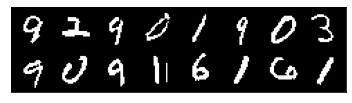

In [44]:
input_images = next(iter(test_loader))[0][:16].to(device)
show(input_images)

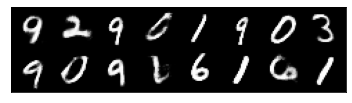

In [45]:
reconstructed_images = vae(input_images)
show(nn.Sigmoid()(reconstructed_images.mu_x))